# 進出場策略 (Entry & Exit Strategies)

## 看一下單一股票的進出場狀況

In [1]:
# 網路上有人提到在使用pandas_datareader前加入這一行，果然可以
# ref: https://stackoverflow.com/questions/50394873/import-pandas-datareader-gives-importerror-cannot-import-name-is-list-like
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like

import ffn

%matplotlib inline

import pandas_datareader.data as web
import pandas as pd
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

In [2]:
# 讀取從指定日期之後的股價資訊
df = web.DataReader("TSLA", 'google', datetime(2016,8,1))

C:\Users\Malo\Anaconda3\lib\site-packages\pandas_datareader\google\daily.py:40: UnstableAPIWarning: 
The Google Finance API has not been stable since late 2017. Requests seem
to fail at random. Failure is especially common when bulk downloading.

  warnings.warn(UNSTABLE_WARNING, UnstableAPIWarning)


RemoteDataError: Unable to read URL: https://finance.google.com/finance/historical?q=TSLA&startdate=Aug+01%2C+2016&enddate=Aug+27%2C+2018&output=csv
Response Text:
b'<html><head><meta http-equiv="content-type" content="text/html; charset=utf-8"/><title>Sorry...</title><style> body { font-family: verdana, arial, sans-serif; background-color: #fff; color: #000; }</style></head><body><div><table><tr><td><b><font face=sans-serif size=10><font color=#4285f4>G</font><font color=#ea4335>o</font><font color=#fbbc05>o</font><font color=#4285f4>g</font><font color=#34a853>l</font><font color=#ea4335>e</font></font></b></td><td style="text-align: left; vertical-align: bottom; padding-bottom: 15px; width: 50%"><div style="border-bottom: 1px solid #dfdfdf;">Sorry...</div></td></tr></table></div><div style="margin-left: 4em;"><h1>We\'re sorry...</h1><p>... but your computer or network may be sending automated queries. To protect our users, we can\'t process your request right now.</p></div><div style="margin-left: 4em;">See <a href="https://support.google.com/websearch/answer/86640">Google Help</a> for more information.<br/><br/></div><div style="text-align: center; border-top: 1px solid #dfdfdf;"><a href="https://www.google.com">Google Home</a></div></body></html>'

In [3]:
# 使用DataReader讀不到，改用另一個自製的function試就ok

import sys
sys.path.append('../modules')
import crawler

# 讀取從指定日期之後的股價資訊
df = crawler.get_quotes("TSLA", datetime(2016,1,1))

In [4]:
# 計算均線
df['20d'] = pd.Series.rolling(df['Close'], window=20).mean()
df['60d'] = pd.Series.rolling(df['Close'], window=60).mean()

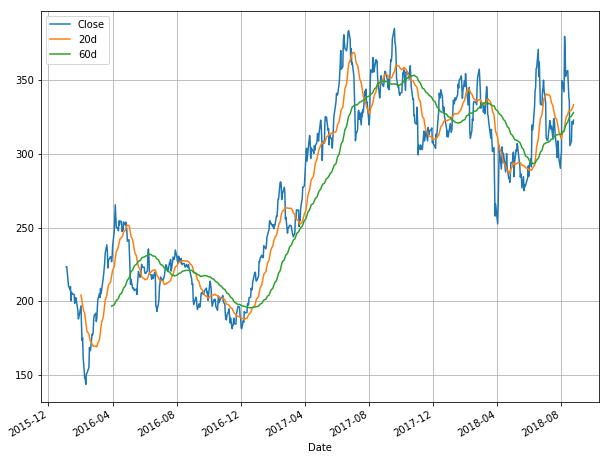

In [5]:
df[['Close','20d','60d']].plot(grid=True, figsize=(10,8))

In [6]:
# Donchian Channel
df['20d_high'] = pd.Series.rolling(df['Close'], window=20).max()
df['10d_low'] = pd.Series.rolling(df['Close'], window=10).min()

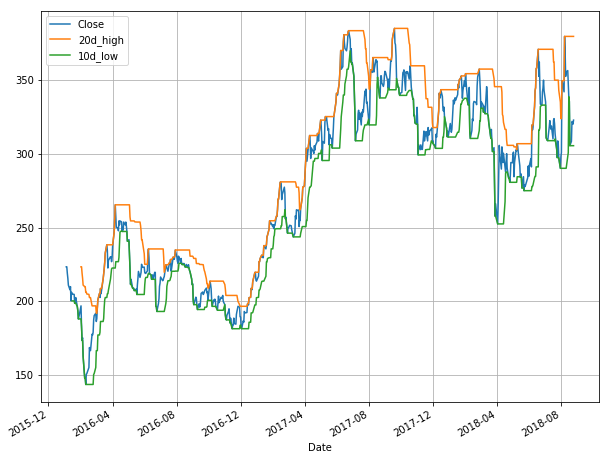

In [7]:
df[['Close','20d_high','10d_low']].plot(grid=True, figsize=(10,8))

## 策略

進出點的計算，可以參考：

https://www.quantstart.com/articles/Backtesting-a-Moving-Average-Crossover-in-Python-with-pandas

In [8]:
# 突破策略
def breakout(df):
    # Donchian Channel
    df['20d_high'] = pd.Series.rolling(df['Close'], window=20).max()
    df['10d_low'] = pd.Series.rolling(df['Close'], window=10).min()

    has_position = False
    df['signals'] = 0
    for t in range(2, df['signals'].size):
        if df['Close'][t] > df['20d_high'][t-1]:
            if not has_position:
                df.loc[df.index[t], 'signals'] = 1
                has_position = True
        elif df['Close'][t] < df['10d_low'][t-1]:
            if has_position:
                df.loc[df.index[t], 'signals'] = -1
                has_position = False

    df['positions'] = df['signals'].cumsum().shift()

    # 底下這一行只是為了要在下面把 signals 跟 positions 畫出來做說明用
    df[['signals', 'positions']].plot(subplots = True, ylim=(-1.1, 1.1), figsize = (10, 8))

In [9]:
def apply_strategy(strategy, df):
    return strategy(df)

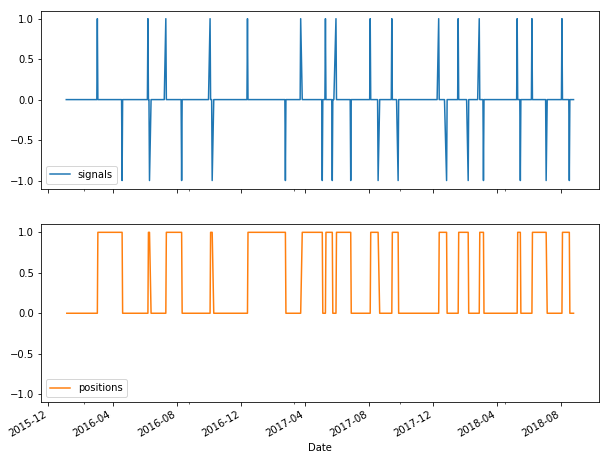

In [10]:
apply_strategy(breakout, df)

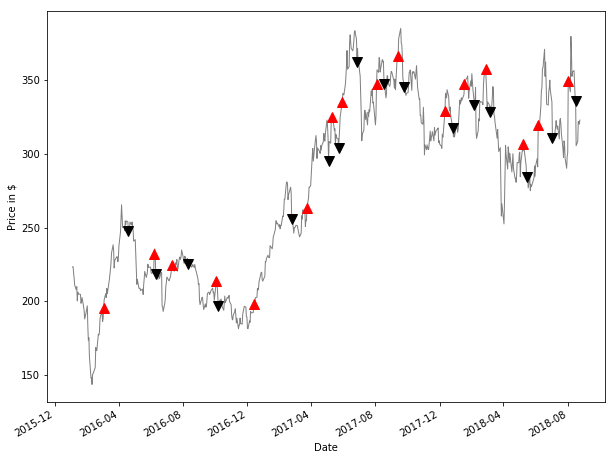

In [11]:
fig = plt.figure()
#fig.patch.set_facecolor('white')     # Set the outer colour to white
ax1 = fig.add_subplot(111,  ylabel='Price in $')
    
df['Close'].plot(ax=ax1, color='gray', lw=1., figsize=(10,8))

# Plot the "buy" trades
ax1.plot(df.loc[df.signals == 1].index,df['Close'][df.signals == 1.0],'^', markersize=10, color='r')

# Plot the "sell" trades
ax1.plot(df.loc[df.signals == -1].index, df['Close'][df.signals == -1.0], 'v', markersize=10, color='k')

## 計算Sharpe Ratio

In [12]:
dailyRet = df['Close'].pct_change()

In [13]:
#假設無風險利率為 4%
#假設一年有252個交易日
excessRet = (dailyRet - 0.04/252)[df['positions']==1]

sharpeRatio = np.sqrt(252.0)*np.mean(excessRet)/np.std(excessRet)

In [14]:
sharpeRatio

0.3803289277661755

## 計算MaxDD跟MaxDDD

In [15]:
cumRet = np.cumprod(1 + excessRet)

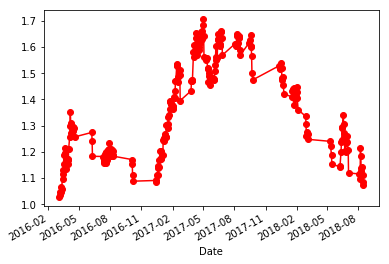

In [16]:
cumRet.plot(style='ro-')

In [17]:
def DrawDownAnalysis(cumRet):
    dd_series = ffn.core.to_drawdown_series(cumRet)
    dd_details = ffn.core.drawdown_details(dd_series)
    return dd_details['drawdown'].min(), dd_details['days'].max()

In [18]:
DrawDownAnalysis(cumRet)

(-0.3704850495868691, 471)